# 20 Newsgroups: Classifyer Comparison

## Quellen

### 5.6.2. The 20 newsgroups text dataset

Einstieg:

* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups  (scikit-learn 1.1.0)

Dort:

* Read more in the [ User Guide > 7.2.2. The 20 newsgroups text dataset](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset)

Examples using sklearn.datasets.fetch_20newsgroups:

* Wir starten hier: [Classification of text documents using sparse features](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py)

Weitere Beispiele:

* [Sample pipeline for text feature extraction and evaluation](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py); nutzt `SGDClassifier`

* nutzt `SGDClassifier`, aber auch sonst interessant? Weiß nicht:  [Semi-supervised Classification on a Text Dataset](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_semi_supervised_newsgroups.html#sphx-glr-auto-examples-semi-supervised-plot-semi-supervised-newsgroups-py)


## Classification of text documents using sparse features

Reproduktion von <https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py>:

* ohne USE_HASHING, ohne SELECT_CHI2
* reduziert um ein paar wenige Classifier, die trotz hoher Trainingszeit keinen guten Score liefern


In [4]:

# Optional feature selection: either False, or an integer: the number of
# features to select
#SELECT_CHI2 = False

In [5]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
     "comp.graphics",
# "sci.space",
]

In [6]:
data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42,
    remove = ('headers', 'footers', 'quotes')  # hinzugefügt JB
)

data_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=42,
    remove = ('headers', 'footers', 'quotes')   # hinzugefügt JB
)
#print("data loaded")

In [7]:
# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names
target_names


['alt.atheism', 'comp.graphics', 'talk.religion.misc']

In [8]:
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print(
    "%d documents - %0.3fMB (training set)" % (len(data_train.data), data_train_size_mb)
)
print("%d documents - %0.3fMB (test set)" % (len(data_test.data), data_test_size_mb))
print("%d categories:" % len(target_names), target_names)


1441 documents - 1.655MB (training set)
959 documents - 1.376MB (test set)
3 categories: ['alt.atheism', 'comp.graphics', 'talk.religion.misc']


In [9]:
data_train.data[:3]

['Those things,\n\twhich ye have both learned, and received,\n\tand heard, and seen in me,\n\tdo:\n\tand the God of peace shall be with you.',
 'Greetings all.\n\tAccording to a FAQ I read, on 30 July 1992, Joshua C. Jensen posted an \narticle on bitmap manipulation (specifically, scaling and perspective) to the \nnewsgroup rec.games.programmer. (article 7716)\n\tThe article included source code in Turbo Pascal with inline assembly \nlanguage.\n\n\tI have been unable to find an archive for this newsgroup, or a current \nemail address for Joshua C. Jensen.\n\tIf anyone has the above details, or a copy of the code, could they \nplease let me know.\tMany thanks.\n\t\t\t\t\tYours gratefully, etc.  Myles.\n',
 '\nAs many people have mentioned, there is no reason why insurers could not\noffer a contract without abortion services for a different premium.\nThe problem is that there is no guarantee that this premium would be\nlower for those who chose this type of contract.  Although you are\nr

In [13]:
set(data_train.target)

{0, 1, 2}

In [11]:
y_train, y_test = data_train.target, data_test.target

In [24]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer

t0 = time()

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
X_train = vectorizer.fit_transform(data_train.data)

duration = time() - t0
print("vectorizer.fit_transform() done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)

vectorizer.fit_transform() done in 0.195131s at 8.481MB/s
n_samples: 1441, n_features: 20052


In [9]:
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)

done in 0.108090s at 12.727MB/s
n_samples: 959, n_features: 20052


In [10]:
feature_names = vectorizer.get_feature_names_out()

In [11]:
import numpy as np
from sklearn import metrics
from sklearn.utils.extmath import density


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


In [12]:

def benchmark(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, "coef_"):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, train_time, test_time

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier


results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"), # solver="sag")
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
#    (KNeighborsClassifier(n_neighbors=10), "kNN"),
#    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty=penalty)))

# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"))
)

# Train NearestCentroid without threshold
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
#print("=" * 80)
#print("Naive Bayes")
#results.append(benchmark(MultinomialNB(alpha=0.01)))
# results.append(benchmark(BernoulliNB(alpha=0.01)))
#results.append(benchmark(ComplementNB(alpha=0.1)))

print("=" * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(
    benchmark(
        Pipeline(
            [
                (
                    "feature_selection",
                    SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),
                ),
                ("classification", LinearSVC(penalty="l2")),
            ]
        )
    )
)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(tol=0.01)
train time: 0.028s
test time:  0.000s
accuracy:   0.779
dimensionality: 20052
density: 1.000000
top 10 keywords per class:
alt.atheism: motto islamic isn atheist deletion bobby religion islam atheists...
comp.graphics: files images 3d image computer looking file hi thanks graphics
talk.religion.misc: koresh blood rosicrucian order christ jesus children fbi ...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.73      0.68      0.70       319
     comp.graphics       0.86      0.97      0.91       389
talk.religion.misc       0.68      0.61      0.64       251

          accuracy                           0.78       959
         macro avg       0.76      0.75      0.75       959
      weighted avg       0.77      0.78      0.77       959

confusion matrix:
[[216  32  71]
 [  9 377   3]
 [ 70  

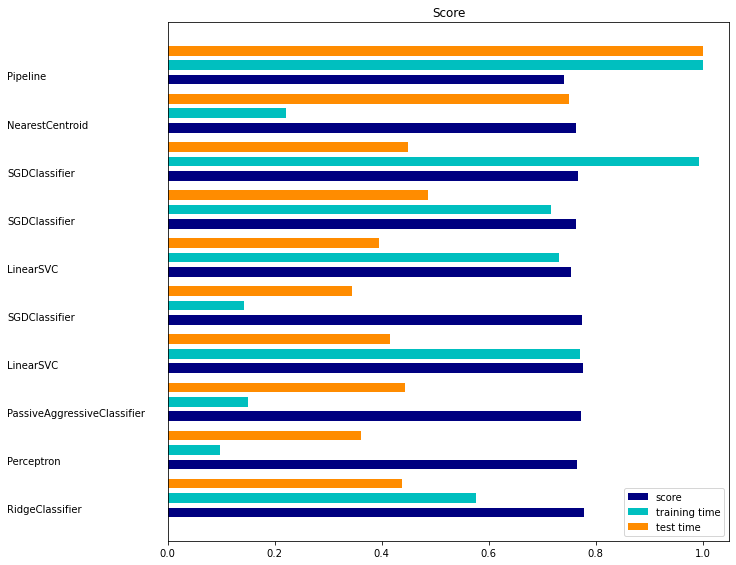

In [16]:
import matplotlib.pyplot as plt

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, 0.2, label="score", color="navy")
plt.barh(indices + 0.3, training_time, 0.2, label="training time", color="c")
plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()